In [7]:
#Dual craft along side Collab

In [8]:
# Operational libraries
import os
import json

# Data manipulation libraries
import pandas as pd
import numpy as np
import math

# Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import tensorflow as tf
# Deep learning libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from cycle_gan import CycleGAN, preprocess_data, train_test_validation_split

""" LSTM model
from lstm_model import (
    prepare_data, 
    train_lstm_model, 
    plot_training_history, 
    evaluate_model, 
    plot_predictions, 
    calculate_rmse
)
"""
# Install Tabulate for csv read and mod


' LSTM model\nfrom lstm_model import (\n    prepare_data, \n    train_lstm_model, \n    plot_training_history, \n    evaluate_model, \n    plot_predictions, \n    calculate_rmse\n)\n'

In [9]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# <center> Anomoly Detection and Attribute Prediction utilizing Deep Learning Methods in multi-stage manufacturing. </center>


# Introduction ***

# Problem Statement ***


Data Source: https://www.kaggle.com/datasets/supergus/multistage-continuousflow-manufacturing-process/data


From the data set's card on it's Kaggle homepage:

Description of physical setup:


The data comes from a continuous flow process.

Sample rate is 1 Hz.

In the first stage, Machines 1, 2,  and 3 operate in parallel, and feed their outputs into a step that combines the flows.
Output from the combiner is measured in 15 locations. These measurements are the primary measurements to predict.
Next, the output flows into a second stage, where Machines 4 and 5 process in series.
Measurements are made again in the same 15 locations. These are the secondary measurements to predict.


Each measurement also has a target or Setpoint (setpoints are included in the first row of data).



Note on variable naming conventions:


* ~.C.Setpoint		Setpoint for Controlled variable

* ~.C.Actual		Actual value of Controlled variable

* ~.U.Actual		Actual value of Uncontrolled variable


Others		Environmental or raw material variables, States / events, etc.


\begin{equation*}
\begin{array}{ccl}
Start col &	End col	&	Description \\
0	&	0	&	Time stamp \\
1	&	2	&	Factory ambient conditions \\
3	&	6	&	First stage, Machine 1, raw material properties (material going in to Machine 1) \\
7	&	14	&	First stage, Machine 1 process variables \\
15	&	18	&	First stage, Machine 2, raw material properties (material going in to Machine 2) \\
19	&	26	&	First stage, Machine 2 process variables \\
27	&	30	&	First stage, Machine 3, raw material properties (material going in to Machine 3) \\
31	&	38	&	First stage, Machine 3 process variables \\
39	&	41	&	Combiner stage process parameters. Here we combines the outputs from Machines 1, 2, and 3. \\
42	&	71	&	PRIMARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each \\
72	&	78	&	Second stage, Machine 4 process variables \\
79	&	85	&	Second stage, Machine 5 process variables \\
86	&	115	&	SECONDARY OUTPUT TO CONTROL: Measurements of 15 features (in mm), along with setpoint or target for each \\
\end{array}
\end{equation*}

# Describe the plan for my EDA and then model building


In [10]:
# Read in the manufacturing process data
factory_df = pd.read_csv('continuous_factory_process.csv')


In [11]:
# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
factory_df.info()

print("\nDataset Shape:")
print("-" * 50)
print(f"Rows: {factory_df.shape[0]}")
print(f"Columns: {factory_df.shape[1]}")

print("\nFirst few rows:")
print("-" * 50)
display(factory_df.head())

print("\nBasic Statistics:")
print("-" * 50)
display(factory_df.describe())

print("\nNumber of Columns with Missing Values:")
print("-" * 50)
print(f"Columns with missing values: {factory_df.isnull().any().sum()}")


Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14088 entries, 0 to 14087
Columns: 116 entries, time_stamp to Stage2.Output.Measurement14.U.Setpoint
dtypes: float64(108), int64(7), object(1)
memory usage: 12.5+ MB

Dataset Shape:
--------------------------------------------------
Rows: 14088
Columns: 116

First few rows:
--------------------------------------------------


,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71



Basic Statistics:
--------------------------------------------------


,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,Machine1.MotorAmperage.U.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
count,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,14088.000000,...,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,1.408800e+04,14088.00,14088.000000,1.408800e+04
mean,15.330759,23.843635,11.851256,205.676320,951.679815,248.868896,1242.764276,72.013330,72.013106,70.333111,...,7.535958e+00,7.930000e+00,5.416515e+00,5.650000e+00,1.972561e+00,1.850000e+00,3.535251e+00,2.89,7.515574,1.171000e+01
std,1.188993,0.373535,0.510309,11.606324,126.662010,3.297820,95.845946,0.063183,0.406313,5.525217,...,1.645785e+00,3.552840e-15,1.182333e+00,8.882099e-16,4.145398e-01,4.441050e-16,4.768244e-01,0.00,2.082948,1.776420e-15
min,13.840000,23.020000,11.540000,200.000000,601.110000,247.000000,231.300000,71.900000,71.300000,44.400000,...,-5.220420e-95,7.930000e+00,-2.703210e-95,5.650000e+00,-6.200020e-96,1.850000e+00,-1.822810e-95,2.89,-3.437021,1.171000e+01
25%,14.040000,23.530000,11.540000,200.000000,963.000000,247.000000,1257.170000,72.000000,71.600000,68.880000,...,7.840000e+00,7.930000e+00,5.560000e+00,5.650000e+00,2.030000e+00,1.850000e+00,3.450000e+00,2.89,7.720000,1.171000e+01
50%,15.120000,23.930000,11.540000,200.000000,963.000000,247.000000,1264.440000,72.000000,72.000000,71.980000,...,7.900000e+00,7.930000e+00,5.630000e+00,5.650000e+00,2.060000e+00,1.850000e+00,3.510000e+00,2.89,7.870000,1.171000e+01
75%,16.630000,24.160000,12.220000,201.000000,1027.430000,251.000000,1273.460000,72.000000,72.400000,72.920000,...,7.950000e+00,7.930000e+00,5.800000e+00,5.650000e+00,2.090000e+00,1.850000e+00,3.760000e+00,2.89,8.080000,1.171000e+01
max,17.240000,24.430000,12.900000,236.000000,1048.060000,257.000000,1331.820000,72.500000,72.700000,88.530000,...,8.590000e+00,7.930000e+00,6.320000e+00,5.650000e+00,5.200000e+00,1.850000e+00,8.000000e+00,2.89,14.260000,1.171000e+01



Number of Columns with Missing Values:
--------------------------------------------------
Columns with missing values: 0


describe the above...

... then candlestick graph

In [12]:
# Lets rename the columns
# Create a dictionary to store the old and new column names
column_mapping = {}

# Machine = Mchn
# Temperature = Temp
# Material = Mat
# Measurement = Meas
# Setpoint = Setp
# Actual = Act
# Controlled = Ctrl
# Uncontrolled = Unctrl
# Environmental = Env
# States = St

# Iterate through columns and create new names in temp dict
for column in factory_df.columns:
    if column != 'time_stamp':  # Keep timestamp column as is
        new_name = ''.join(' ' + c if c.isupper() else c for c in column)
        new_name = ''.join(' ' + c if c.isdigit() else c for c in new_name)
        new_name = new_name.replace('.', ' ')
        new_name = new_name.replace('Machine', 'Mchn')
        new_name = new_name.replace('Temperature', 'Temp') 
        new_name = new_name.replace('Material', 'Mat')
        new_name = new_name.replace('Measurement', 'Meas')
        new_name = new_name.replace('Setpoint', 'Setp')
        new_name = new_name.replace('Actual', 'Act')
        new_name = new_name.replace('Controlled', 'Ctrl')
        new_name = new_name.replace('Uncontrolled', 'Unctrl')
        new_name = new_name.replace('Environmental', 'Env')
        new_name = new_name.replace('States', 'St')
        new_name = new_name.replace('Output', 'Out')
        column_mapping[column] = new_name

# Rename the columns using the mapping
factory_df = factory_df.rename(columns=column_mapping)
factory_df.head()

,time_stamp,Ambient Conditions Ambient Humidity U Act,Ambient Conditions Ambient Temp U Act,Mchn 1 Raw Mat Property 1,Mchn 1 Raw Mat Property 2,Mchn 1 Raw Mat Property 3,Mchn 1 Raw Mat Property 4,Mchn 1 Raw Mat Feeder Parameter U Act,Mchn 1 Zone 1 Temp C Act,Mchn 1 Zone 2 Temp C Act,...,Stage 2 Out Meas 1 0 U Act,Stage 2 Out Meas 1 0 U Setp,Stage 2 Out Meas 1 1 U Act,Stage 2 Out Meas 1 1 U Setp,Stage 2 Out Meas 1 2 U Act,Stage 2 Out Meas 1 2 U Setp,Stage 2 Out Meas 1 3 U Act,Stage 2 Out Meas 1 3 U Setp,Stage 2 Out Meas 1 4 U Act,Stage 2 Out Meas 1 4 U Setp
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


In [13]:
# Lets iterate over each column to see if wer can spot any crazy outliers


# Calculate number of outliers (>3 std dev from mean) for each column
outlier_counts = {}
for column in factory_df.columns:
    if factory_df[column].dtype in ['float64', 'int64']:  # Only analyze numeric columns
        mean = factory_df[column].mean()
        std = factory_df[column].std()
        outliers = factory_df[column][(factory_df[column] < mean - 3*std) | 
                                    (factory_df[column] > mean + 3*std)]
        outlier_counts[column] = len(outliers)

# Convert to dataframe and sort by number of outliers
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', 
                                   columns=['Number of Outliers'])
outlier_df = outlier_df.sort_values('Number of Outliers', ascending=False)

print("\nNumber of outliers (>3 std dev) per column:")
print("-" * 50)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(outlier_df)



Number of outliers (>3 std dev) per column:
--------------------------------------------------


,Number of Outliers
Stage 2 Out Meas 0 U Act,1227
Stage 2 Out Meas 8 U Act,977
Stage 2 Out Meas 1 4 U Act,918
Stage 2 Out Meas 4 U Act,899
Stage 1 Out Meas 8 U Act,781
Stage 2 Out Meas 1 U Act,780
Stage 2 Out Meas 3 U Act,776
Stage 1 Out Meas 9 U Act,726
Stage 1 Out Meas 5 U Act,641
Stage 2 Out Meas 1 0 U Act,638


The majority of columns with values greater than 3 standard deviations are  Output variables, or in other words, the predictors. However while looking at this I realized that 3 standard deviations is a good method.... if the data is normally distributed. Let's try and inspect the distributions of each.


In [14]:
# Initialize dataframe for statistics
factory_summary = pd.DataFrame()

# Seperate Time Column
sub_factory_df = factory_df.drop('time_stamp', axis = 1)

# Iterate through the columns calculating our stats
for column in sub_factory_df.columns:
    if sub_factory_df[column].dtype in ['float64', 'int64']:
        factory_summary.loc[column, 'Mean'] = sub_factory_df[column].mean()
        factory_summary.loc[column, 'Std Dev'] = sub_factory_df[column].std()
        factory_summary.loc[column, 'Skewness'] = sub_factory_df[column].skew()
        factory_summary.loc[column, 'Kurtosis'] = sub_factory_df[column].kurt()
        factory_summary.loc[column, 'IQR'] = sub_factory_df[column].quantile(0.75) - sub_factory_df[column].quantile(0.25)

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(factory_summary)

# Save factory summary statistics to CSV
factory_summary.to_csv('factory_summary_statistics.csv')


,Mean,Std Dev,Skewness,Kurtosis,IQR
Ambient Conditions Ambient Humidity U Act,15.330759,1.188993e+00,0.113315,-1.639747,2.5900
Ambient Conditions Ambient Temp U Act,23.843635,3.735350e-01,-0.532854,-0.688510,0.6300
Mchn 1 Raw Mat Property 1,11.851256,5.103091e-01,1.162976,-0.413131,0.6800
Mchn 1 Raw Mat Property 2,205.676320,1.160632e+01,1.921282,2.187776,1.0000
Mchn 1 Raw Mat Property 3,951.679815,1.266620e+02,-2.220318,3.485070,64.4300
Mchn 1 Raw Mat Property 4,248.868896,3.297820e+00,1.596464,1.190369,4.0000
Mchn 1 Raw Mat Feeder Parameter U Act,1242.764276,9.584595e+01,-4.487157,22.806924,16.2900
Mchn 1 Zone 1 Temp C Act,72.013330,6.318299e-02,4.160693,23.209066,0.0000
Mchn 1 Zone 2 Temp C Act,72.013106,4.063128e-01,0.029851,-1.393234,0.8000
Mchn 1 Motor Amperage U Act,70.333111,5.525217e+00,-1.587474,4.663747,4.0400


In [15]:
df = pd.read_csv('factory_summary_statistics.csv')
df['Unnamed: 0'] = df['Unnamed: 0'].astype(str)

# Melt the dataframe to long format
df_melted = df.melt(id_vars='Unnamed: 0', value_vars=['Mean', 'Std Dev', 'Skewness', 'Kurtosis', 'IQR'])

# Rename the columns
df_melted.columns = ['Statistic', 'Measure', 'Value']

# Print the first 5 rows of the dataframe
print(df_melted.head().to_markdown(index=False, numalign="left", stralign="left"))

# Print the column name and their data types
print(df_melted.info())


| Statistic                                    | Measure   | Value   |
|:---------------------------------------------|:----------|:--------|
| Ambient Conditions  Ambient Humidity  U  Act | Mean      | 15.3308 |
| Ambient Conditions  Ambient Temp  U  Act     | Mean      | 23.8436 |
| Mchn 1  Raw Mat  Property 1                  | Mean      | 11.8513 |
| Mchn 1  Raw Mat  Property 2                  | Mean      | 205.676 |
| Mchn 1  Raw Mat  Property 3                  | Mean      | 951.68  |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Statistic  575 non-null    object 
 1   Measure    575 non-null    object 
 2   Value      575 non-null    float64
dtypes: float64(1), object(2)
memory usage: 13.6+ KB
None


In [16]:
alt.renderers.enable('jupyterlab')
chart = alt.Chart(df_melted).mark_rect().encode(
    # Set `Measure` on the x-axis and `Statistic` on the y-axis
    x=alt.X('Measure', title='Measure'),
    y=alt.Y('Statistic', title='Statistic'),
    # Use `Value` for color intensity
    color=alt.Color('Value', title='Value'),
    # Add tooltips for each column
    tooltip=['Measure', 'Statistic', 'Value']
).properties(
    # Set the title of the chart
    title='Distribution of Summary Statistics'
).interactive()  # Make the chart interactive
display(chart)
# Save the chart as a JSON file
chart.save('distribution_heatmap.json', renderer = 'notebook')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# LSTM Helper Functions

In [17]:
def create_sequences(data, seq_length, output_cols):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Get sequence of features
        seq = data.iloc[i:i+seq_length].values
        # Get target (next time step values for output measurements)
        target = data.iloc[i+seq_length][output_cols].values
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

In [18]:
def prepare_data(train_df, test_df, seq_length=60):
    """
    Prepare data for LSTM model
    
    Parameters:
    -----------
    train_df : pandas DataFrame
        Training data
    test_df : pandas DataFrame
        Testing data
    seq_length : int
        Sequence length for LSTM input
        
    Returns:
    --------
    X_train, y_train, X_test, y_test, scaler, output_cols, output_indices
    """
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # Convert timestamp to datetime and set as index if not already done
    if 'time_stamp' in train_df.columns:
        train_df['time_stamp'] = pd.to_datetime(train_df['time_stamp'])
        train_df.set_index('time_stamp', inplace=True)
        test_df['time_stamp'] = pd.to_datetime(test_df['time_stamp'])
        test_df.set_index('time_stamp', inplace=True)

    # Select both Stage 1 and Stage 2 output measurements
    output_cols = [col for col in train_df.columns if 
                   (('Stage 1' in col or 'Stage 2' in col) and 'Out' in col and 'Act' in col)]
    
    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
    test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)
    
    # Create sequences for LSTM
    X_train, y_train = create_sequences(train_scaled, seq_length, output_cols)
    X_test, y_test = create_sequences(test_scaled, seq_length, output_cols)
    
    # Get the indices of output columns in the original dataframe
    output_indices = [train_df.columns.get_loc(col) for col in output_cols]
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test, scaler, output_cols, output_indices

In [19]:
def plot_predictions(y_test_inv, pred_inv, output_cols, n_samples=100, n_features=5):
    """
    Plot predictions vs actual values
    
    Parameters:
    -----------
    y_test_inv : numpy array
        Inverse transformed actual values
    pred_inv : numpy array
        Inverse transformed predictions
    output_cols : list
        Names of output columns
    n_samples : int
        Number of samples to plot
    n_features : int
        Number of features to plot
    """
    plt.figure(figsize=(15, 10))
    for i in range(min(n_features, len(output_cols))):
        plt.subplot(n_features, 1, i+1)
        plt.plot(y_test_inv[:n_samples, i], label='Actual')
        plt.plot(pred_inv[:n_samples, i], label='Predicted')
        plt.title(f'Predictions for {output_cols[i]}')
        plt.legend()
    plt.tight_layout()
    plt.show()



In [20]:
def calculate_rmse(y_test_inv, pred_inv, output_cols):
    """
    Calculate RMSE for each output feature
    
    Parameters:
    -----------
    y_test_inv : numpy array
        Inverse transformed actual values
    pred_inv : numpy array
        Inverse transformed predictions
    output_cols : list
        Names of output columns
    """
    print("Root Mean Squared Error (RMSE) for each output feature:")
    for i, col in enumerate(output_cols):
        rmse = math.sqrt(mean_squared_error(y_test_inv[:, i], pred_inv[:, i]))
        print(f"{col}: {rmse:.4f}")
    
    # Calculate overall RMSE
    overall_rmse = math.sqrt(mean_squared_error(y_test_inv, pred_inv))
    print(f"\nOverall RMSE: {overall_rmse:.4f}")

# Example usage:
"""
# Assuming train_df and test_df are already defined
X_train, y_train, X_test, y_test, scaler, output_cols, output_indices = prepare_data(train_df, test_df)

# Get input and output shapes
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
output_shape = y_train.shape[1]  # Number of output features

# Train the model
lstm_model, history = train_lstm_model(X_train, y_train, input_shape, output_shape)

# Plot training history
plot_training_history(history)

# Evaluate the model
y_test_inv, pred_inv = evaluate_model(lstm_model, X_test, y_test, scaler, output_indices)

# Plot predictions
plot_predictions(y_test_inv, pred_inv, output_cols)

# Calculate RMSE
calculate_rmse(y_test_inv, pred_inv, output_cols)
""" 

'\n# Assuming train_df and test_df are already defined\nX_train, y_train, X_test, y_test, scaler, output_cols, output_indices = prepare_data(train_df, test_df)\n\n# Get input and output shapes\ninput_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)\noutput_shape = y_train.shape[1]  # Number of output features\n\n# Train the model\nlstm_model, history = train_lstm_model(X_train, y_train, input_shape, output_shape)\n\n# Plot training history\nplot_training_history(history)\n\n# Evaluate the model\ny_test_inv, pred_inv = evaluate_model(lstm_model, X_test, y_test, scaler, output_indices)\n\n# Plot predictions\nplot_predictions(y_test_inv, pred_inv, output_cols)\n\n# Calculate RMSE\ncalculate_rmse(y_test_inv, pred_inv, output_cols)\n'

In [21]:
def plot_training_history(history):
    """
    Plot training history
    
    Parameters:
    -----------
    history : Keras history object
        Training history
    """
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Data Split

In [22]:
# Now we split out data into a trianing and testing batch
# Split the data into training and testing sets (80-20 split)
train_size = int(0.8 * len(factory_df))
train_df = factory_df[:train_size]
test_df = factory_df[train_size:]

print(f"Training set size: {len(train_df)} samples")
print(f"Testing set size: {len(test_df)} samples")


Training set size: 11270 samples
Testing set size: 2818 samples


Prepare for the Long Short Term Mermory

In [23]:
# Prepare data for LSTM
print("Preparing data for LSTM...")
X_train, y_train, X_test, y_test, scaler, output_cols, output_indices = prepare_data(train_df, test_df, seq_length=60)

# Get input and output shapes
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
output_shape = y_train.shape[1]  # Number of output features

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")
print(f"Number of output features: {len(output_cols)}")
print(f"Output features: {output_cols[:3]}...")  # Show first 3 output features


Preparing data for LSTM...
X_train shape: (11210, 60, 115)
y_train shape: (11210, 30)
X_test shape: (2758, 60, 115)
y_test shape: (2758, 30)
Input shape: (60, 115)
Output shape: 30
Number of output features: 30
Output features: [' Stage 1  Out  Meas 0  U  Act', ' Stage 1  Out  Meas 1  U  Act', ' Stage 1  Out  Meas 2  U  Act']...


# Set up the architecture and Create model functions

In [24]:
def create_lstm_model(input_shape, output_shape):
    """
    Create a simple LSTM model
    
    Parameters:
    -----------
    input_shape : tuple
        Shape of input data (sequence_length, num_features)
    output_shape : int
        Number of output features
        
    Returns:
    --------
    Compiled Keras model
    """
    model = Sequential()
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    
    # Second LSTM layer
    model.add(LSTM(32, activation='relu'))
    
    # Dropout for regularization
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Dense hidden layer
    model.add(Dense(32, activation='relu'))
    
    # Output layer
    model.add(Dense(output_shape))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    return model

# Train  and Validate Functions

In [25]:
def train_lstm_model(X_train, y_train, input_shape, output_shape, epochs=50, batch_size=32):
    """
    Train the LSTM model
    
    Parameters:
    -----------
    X_train : numpy array
        Training input data
    y_train : numpy array
        Training target data
    input_shape : tuple
        Shape of input data (sequence_length, num_features)
    output_shape : int
        Number of output features
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training
        
    Returns:
    --------
    Trained model and training history
    """
    # Create model
    lstm_model = create_lstm_model(input_shape, output_shape)
    lstm_model.summary()
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)
    
    # Train the model
    history = lstm_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    
    return lstm_model, history

In [26]:
def evaluate_model(model, X_test, y_test, scaler, output_indices):
    """
    Evaluate the model on test data
    
    Parameters:
    -----------
    model : Keras model
        Trained LSTM model
    X_test : numpy array
        Test input data
    y_test : numpy array
        Test target data
    scaler : sklearn scaler
        Fitted scaler for inverse transformation
    output_indices : list
        Indices of output columns in the original dataframe
    """
    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_test_inv = inverse_transform_output(y_test, output_indices, scaler)
    pred_inv = inverse_transform_output(predictions, output_indices, scaler)
    
    return y_test_inv, pred_inv

In [27]:
def inverse_transform_output(scaled_data, output_indices, scaler):
    """
    Inverse transform the scaled data for specific columns
    
    Parameters:
    -----------
    scaled_data : numpy array
        Scaled data to inverse transform
    output_indices : list
        Indices of output columns in the original dataframe
    scaler : sklearn scaler
        Fitted scaler for inverse transformation
        
    Returns:
    --------
    Inverse transformed data
    """
    # Get the number of features in the original data
    n_features = len(scaler.scale_)
    
    # Create a dummy array of zeros with the same shape as the original data
    dummy = np.zeros((scaled_data.shape[0], n_features))
    
    # Place the scaled output data in the correct columns
    for i, idx in enumerate(output_indices):
        dummy[:, idx] = scaled_data[:, i]
        
    # Inverse transform
    dummy_inversed = scaler.inverse_transform(dummy)
    
    # Extract only the output columns
    return dummy_inversed[:, output_indices]

In [28]:
# Train the model
print("\nTraining LSTM model...")
lstm_model, history = train_lstm_model(
    X_train, y_train, 
    input_shape, output_shape, 
    epochs=20,  # Reduced for demonstration
    batch_size=32
)


Training LSTM model...


C:\Users\micha\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        46,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,542 (236.49 KB)

 Trainable params: 60,542 (236.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - loss: 0.1016 - mae: 0.2270 - val_loss: 0.0332 - val_mae: 0.1096
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0219 - mae: 0.1001 - val_loss: 0.0326 - val_mae: 0.1042
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0141 - mae: 0.0717 - val_loss: 0.0319 - val_mae: 0.0864
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0119 - mae: 0.0613 - val_loss: 0.0310 - val_mae: 0.0865
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0108 - mae: 0.0552 - val_loss: 0.0312 - val_mae: 0.0777
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0100 - mae: 0.0512 - val_loss: 0.0303 - val_mae: 0.0842
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0096 - mae: 0.0487 - val_loss: 0.0302 - val_mae: 0.0793
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0089 - mae: 0.0458 - val_loss: 0.0303 - val_mae: 0.0790
Epoch 9/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 


Plotting training history...


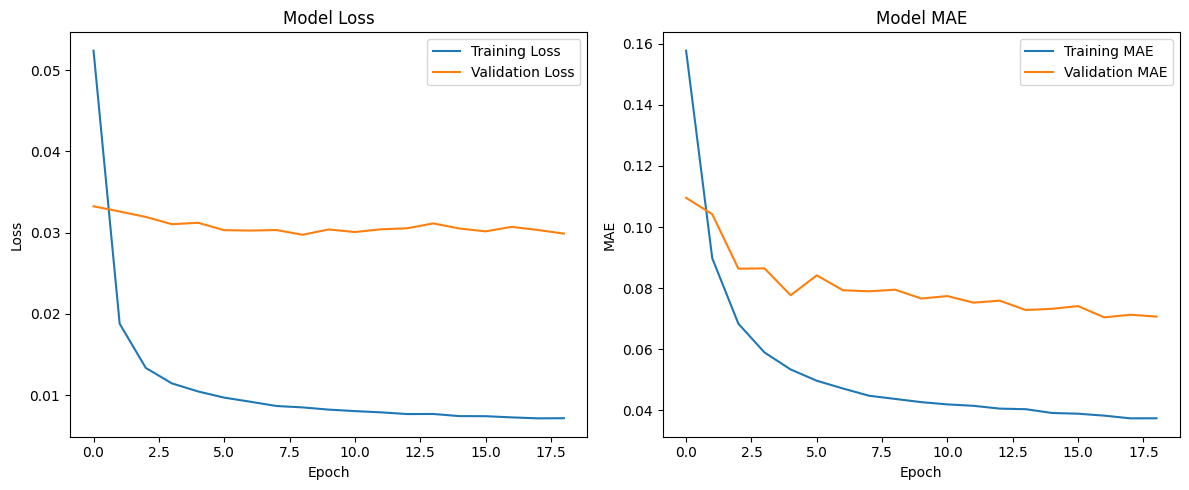

In [29]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)


In [30]:

# Evaluate the model
print("\nEvaluating model on test data...")
y_test_inv, pred_inv = evaluate_model(lstm_model, X_test, y_test, scaler, output_indices)




Evaluating model on test data...
Test Loss: 0.0375
Test MAE: 0.0881
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step



Plotting predictions vs actual values...


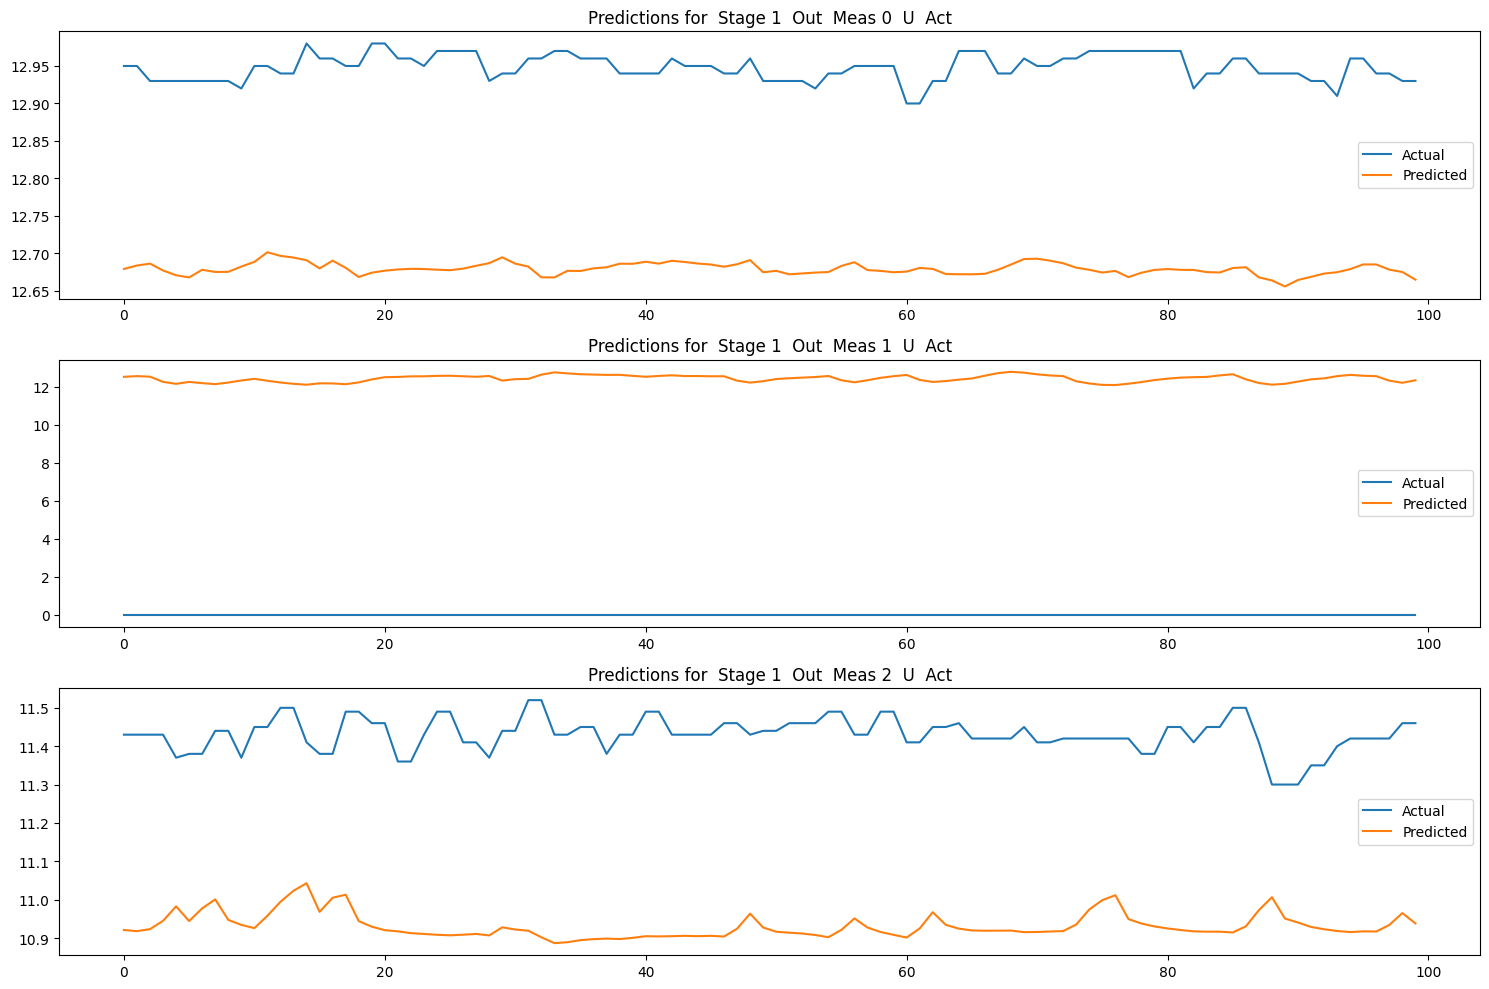

In [31]:
# Plot predictions
print("\nPlotting predictions vs actual values...")
plot_predictions(y_test_inv, pred_inv, output_cols, n_samples=100, n_features=3)


In [32]:

# Calculate RMSE
print("\nCalculating RMSE for each output feature...")
calculate_rmse(y_test_inv, pred_inv, output_cols)

print("\nLSTM model training and evaluation complete!") 


Calculating RMSE for each output feature...
Root Mean Squared Error (RMSE) for each output feature:
 Stage 1  Out  Meas 0  U  Act: 0.1665
 Stage 1  Out  Meas 1  U  Act: 11.7131
 Stage 1  Out  Meas 2  U  Act: 0.4170
 Stage 1  Out  Meas 3  U  Act: 0.7955
 Stage 1  Out  Meas 4  U  Act: 5.1850
 Stage 1  Out  Meas 5  U  Act: 0.5041
 Stage 1  Out  Meas 6  U  Act: 0.9599
 Stage 1  Out  Meas 7  U  Act: 0.3540
 Stage 1  Out  Meas 8  U  Act: 1.5668
 Stage 1  Out  Meas 9  U  Act: 1.2571
 Stage 1  Out  Meas 1 0  U  Act: 0.2336
 Stage 1  Out  Meas 1 1  U  Act: 0.3002
 Stage 1  Out  Meas 1 2  U  Act: 0.0855
 Stage 1  Out  Meas 1 3  U  Act: 0.8125
 Stage 1  Out  Meas 1 4  U  Act: 6.8956
 Stage 2  Out  Meas 0  U  Act: 2.1293
 Stage 2  Out  Meas 1  U  Act: 0.6266
 Stage 2  Out  Meas 2  U  Act: 0.7388
 Stage 2  Out  Meas 3  U  Act: 0.5364
 Stage 2  Out  Meas 4  U  Act: 6.2877
 Stage 2  Out  Meas 5  U  Act: 0.3023
 Stage 2  Out  Meas 6  U  Act: 0.2019
 Stage 2  Out  Meas 7  U  Act: 0.1197
 Stage 2  Out 

In [33]:
def calculate_normalized_errors(y_true, y_pred):
    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Calculate NRMSE (normalized by the range of the true values)
    nrmse_range = rmse / (np.max(y_true) - np.min(y_true))
    
    # Calculate NRMSE (normalized by the mean of the true values)
    nrmse_mean = rmse / np.mean(y_true)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    # Adding small epsilon to avoid division by zero
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    return {
        'rmse': rmse,
        'nrmse_range': nrmse_range,
        'nrmse_mean': nrmse_mean,
        'mape': mape
    }

In [34]:
y_pred = lstm_model.predict(X_test)  # Assuming X_test is your test input data

# For each output feature
normalized_metrics = {}
# Assuming y_test and y_pred are numpy arrays with shape (n_samples, n_features)
n_features = y_test.shape[1]  # Get number of features

for i in range(n_features):
    feature_name = f"Feature_{i}"  # Or use your actual feature names if you have them
    metrics = calculate_normalized_errors(
        y_test[:, i],
        y_pred[:, i]
    )
    normalized_metrics[feature_name] = metrics

# Print results
for feature, metrics in normalized_metrics.items():
    print(f"\nMetrics for {feature}:")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"NRMSE (range): {metrics['nrmse_range']:.4f} - Error relative to data range")
    print(f"NRMSE (mean): {metrics['nrmse_mean']:.4f} - Error relative to mean value")
    print(f"MAPE: {metrics['mape']:.2f}% - Average percentage error")

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Metrics for Feature_0:
RMSE: 0.0080
NRMSE (range): 0.3398 - Error relative to data range
NRMSE (mean): 0.0129 - Error relative to mean value
MAPE: 1.09% - Average percentage error

Metrics for Feature_1:
RMSE: 0.5259
NRMSE (range): 0.6399 - Error relative to data range
NRMSE (mean): 3.1478 - Error relative to mean value
MAPE: 365.94% - Average percentage error

Metrics for Feature_2:
RMSE: 0.0147
NRMSE (range): 0.0948 - Error relative to data range
NRMSE (mean): 0.0256 - Error relative to mean value
MAPE: 1.99% - Average percentage error

Metrics for Feature_3:
RMSE: 0.0303
NRMSE (range): 1.3259 - Error relative to data range
NRMSE (mean): 0.0370 - Error relative to mean value
MAPE: 3.66% - Average percentage error

Metrics for Feature_4:
RMSE: 0.1493
NRMSE (range): 0.1221 - Error relative to data range
NRMSE (mean): 0.1544 - Error relative to mean value
MAPE: 16695469431.63% - Average percentage error

Metrics for Feature_5:
RMSE: 0.0912
NRMSE (

C:\Users\micha\AppData\Local\Temp\ipykernel_20876\105450877.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  nrmse_range = rmse / (np.max(y_true) - np.min(y_true))


# Prepare for cycle Gan


In [35]:

# Configuration parameters
EPOCHS = 100
BATCH_SIZE = 64
GEN_LEARNING_RATE = 0.0002
DISC_LEARNING_RATE = 0.0002
GEN_HIDDEN_LAYERS = [256, 128, 64]
DISC_HIDDEN_LAYERS = [64, 32, 16]
GEN_DROPOUT_RATE = 0.2
DISC_DROPOUT_RATE = 0.3
LAMBDA_CYCLE = 10.0
LAMBDA_IDENTITY = 1.0
VALIDATE_EVERY = 5
SAMPLE_INTERVAL = 5
SAVE_MODEL_INTERVAL = 20


In [ ]:


class CycleGAN:
    def __init__(self, 
                 input_dims,
                 stage1_dims=15,  # 15 primary measurements 
                 stage2_dims=15,  # 15 secondary measurements
                 gen_hidden_layers=[256, 128, 64],
                 disc_hidden_layers=[64, 32, 16],
                 gen_dropout_rate=0.2,
                 disc_dropout_rate=0.2,
                 gen_learning_rate=0.0002,
                 disc_learning_rate=0.0002,
                 lambda_cycle=10.0,
                 lambda_identity=1.0):
        """
        Initialize the CycleGAN model for manufacturing process prediction.
        
        Parameters:
        -----------
        input_dims : int
            Dimension of the input features (e.g., machine parameters, conditions)
        stage1_dims : int
            Dimension of Stage 1 measurements (primary outputs)
        stage2_dims : int
            Dimension of Stage 2 measurements (secondary outputs)
        gen_hidden_layers : list
            List of hidden layer sizes for the generators
        disc_hidden_layers : list
            List of hidden layer sizes for the discriminators
        gen_dropout_rate : float
            Dropout rate for the generator
        disc_dropout_rate : float
            Dropout rate for the discriminator
        gen_learning_rate : float
            Learning rate for the generator
        disc_learning_rate : float
            Learning rate for the discriminator
        lambda_cycle : float
            Weight for cycle consistency loss
        lambda_identity : float
            Weight for identity mapping loss
        """
        self.input_dims = input_dims
        self.stage1_dims = stage1_dims
        self.stage2_dims = stage2_dims
        
        self.gen_hidden_layers = gen_hidden_layers
        self.disc_hidden_layers = disc_hidden_layers
        
        self.gen_dropout_rate = gen_dropout_rate
        self.disc_dropout_rate = disc_dropout_rate
        
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        
        # Initialize optimizers
        self.gen_optimizer = Adam(learning_rate=gen_learning_rate, beta_1=0.5)
        self.disc_optimizer = Adam(learning_rate=disc_learning_rate, beta_1=0.5)
        
        # Build the models
        self._build_generators()
        self._build_discriminators()
        self._build_combined_models()
        
        # Initialize history tracking
        self.history = {
            'gen_loss': [],
            'disc_loss': [],
            'cycle_loss': [],
            'identity_loss': [],
            'g_s1_to_s2_loss': [],
            'g_s2_to_s1_loss': [],
            'd_s1_loss': [],
            'd_s2_loss': []
        }

    def _build_generators(self):
        """Build the generator models:
        1. G_S1_to_S2: Maps input + Stage 1 measurements to Stage 2 measurements
        2. G_S2_to_S1: Maps input + Stage 2 measurements to Stage 1 measurements
        """
        # Generator: Input + Stage 1 -> Stage 2
        input_features = Input(shape=(self.input_dims,), name='input_features_s1_to_s2')
        stage1_measurements = Input(shape=(self.stage1_dims,), name='stage1_measurements')
        
        # Concatenate inputs
        x = Concatenate()([input_features, stage1_measurements])
        
        # Build hidden layers
        for i, units in enumerate(self.gen_hidden_layers):
            x = Dense(units, name=f'g_s1_to_s2_dense_{i}')(x)
            x = LeakyReLU(0.2)(x)
            if self.gen_dropout_rate > 0:
                x = Dropout(self.gen_dropout_rate)(x)
        
        # Output layer
        stage2_pred = Dense(self.stage2_dims, activation='linear', name='stage2_predictions')(x)
        
        # Define the model
        self.G_S1_to_S2 = Model([input_features, stage1_measurements], stage2_pred, name='generator_s1_to_s2')
        
        # Generator: Input + Stage 2 -> Stage 1
        input_features = Input(shape=(self.input_dims,), name='input_features_s2_to_s1')
        stage2_measurements = Input(shape=(self.stage2_dims,), name='stage2_measurements')
        
        # Concatenate inputs
        x = Concatenate()([input_features, stage2_measurements])
        
        # Build hidden layers
        for i, units in enumerate(self.gen_hidden_layers):
            x = Dense(units, name=f'g_s2_to_s1_dense_{i}')(x)
            x = LeakyReLU(0.2)(x)
            if self.gen_dropout_rate > 0:
                x = Dropout(self.gen_dropout_rate)(x)
        
        # Output layer
        stage1_pred = Dense(self.stage1_dims, activation='linear', name='stage1_predictions')(x)
        
        # Define the model
        self.G_S2_to_S1 = Model([input_features, stage2_measurements], stage1_pred, name='generator_s2_to_s1')
        
        print("Generator models summary:")
        self.G_S1_to_S2.summary()
        self.G_S2_to_S1.summary()

    def _build_discriminators(self):
        """Build the discriminator models:
        1. D_S1: Determines if Stage 1 measurements are real or generated
        2. D_S2: Determines if Stage 2 measurements are real or generated
        """
        # Discriminator for Stage 1 measurements
        input_features = Input(shape=(self.input_dims,), name='input_features_d_s1')
        stage1_measurements = Input(shape=(self.stage1_dims,), name='stage1_measurements_disc')
        
        # Concatenate inputs
        x = Concatenate()([input_features, stage1_measurements])
        
        # Build hidden layers
        for i, units in enumerate(self.disc_hidden_layers):
            x = Dense(units, name=f'd_s1_dense_{i}')(x)
            x = LeakyReLU(0.2)(x)
            if self.disc_dropout_rate > 0:
                x = Dropout(self.disc_dropout_rate)(x)
        
        # Output layer - single neuron with sigmoid for real/fake classification
        validity = Dense(1, activation='sigmoid', name='d_s1_validity')(x)
        
        # Define the model
        self.D_S1 = Model([input_features, stage1_measurements], validity, name='discriminator_s1')
        self.D_S1.compile(loss='binary_crossentropy', optimizer=self.disc_optimizer, metrics=['accuracy'])
        
        # Discriminator for Stage 2 measurements
        input_features = Input(shape=(self.input_dims,), name='input_features_d_s2')
        stage2_measurements = Input(shape=(self.stage2_dims,), name='stage2_measurements_disc')
        
        # Concatenate inputs
        x = Concatenate()([input_features, stage2_measurements])
        
        # Build hidden layers
        for i, units in enumerate(self.disc_hidden_layers):
            x = Dense(units, name=f'd_s2_dense_{i}')(x)
            x = LeakyReLU(0.2)(x)
            if self.disc_dropout_rate > 0:
                x = Dropout(self.disc_dropout_rate)(x)
        
        # Output layer - single neuron with sigmoid for real/fake classification
        validity = Dense(1, activation='sigmoid', name='d_s2_validity')(x)
        
        # Define the model
        self.D_S2 = Model([input_features, stage2_measurements], validity, name='discriminator_s2')
        self.D_S2.compile(loss='binary_crossentropy', optimizer=self.disc_optimizer, metrics=['accuracy'])
        
        print("Discriminator models summary:")
        self.D_S1.summary()
        self.D_S2.summary()

    def _build_combined_models(self):
        """
        Build the combined models for cycle consistency training
        """
        # Input shapes
        input_features = Input(shape=(self.input_dims,), name='input_features_combined')
        stage1_measurements = Input(shape=(self.stage1_dims,), name='stage1_measurements_combined')
        stage2_measurements = Input(shape=(self.stage2_dims,), name='stage2_measurements_combined')
        
        # Freeze the discriminators during generator training
        self.D_S1.trainable = False
        self.D_S2.trainable = False
        
        # Cycle S1 -> S2 -> S1
        fake_stage2 = self.G_S1_to_S2([input_features, stage1_measurements])
        valid_stage2 = self.D_S2([input_features, fake_stage2])
        reconstructed_stage1 = self.G_S2_to_S1([input_features, fake_stage2])
        
        # Cycle S2 -> S1 -> S2
        fake_stage1 = self.G_S2_to_S1([input_features, stage2_measurements])
        valid_stage1 = self.D_S1([input_features, fake_stage1])
        reconstructed_stage2 = self.G_S1_to_S2([input_features, fake_stage1])
        
        # Identity mapping
        identity_stage1 = self.G_S2_to_S1([input_features, stage1_measurements])
        identity_stage2 = self.G_S1_to_S2([input_features, stage2_measurements])
        
        # Combined model
        self.combined = Model(
            inputs=[input_features, stage1_measurements, stage2_measurements],
            outputs=[
                valid_stage1, valid_stage2,                     # Adversarial loss
                reconstructed_stage1, reconstructed_stage2,     # Cycle consistency loss
                identity_stage1, identity_stage2                # Identity loss
            ],
            name='combined_cyclegan'
        )
        
        # Compile the combined model
        self.combined.compile(
            loss=['binary_crossentropy', 'binary_crossentropy',  # Adversarial loss
                 'mae', 'mae',                                   # Cycle loss
                 'mae', 'mae'],                                  # Identity loss
            loss_weights=[1, 1,                                  # Adversarial loss
                         self.lambda_cycle, self.lambda_cycle,   # Cycle loss
                         self.lambda_identity, self.lambda_identity],  # Identity loss
            optimizer=self.gen_optimizer
        )
        
        print("Combined model created")

    def train(self, 
              input_features, 
              stage1_measurements, 
              stage2_measurements,
              epochs=100, 
              batch_size=32, 
              validate_every=10,
              sample_interval=10, 
              save_model_interval=50,
              validation_data=None):
        """
        Train the CycleGAN model
        
        Parameters:
        -----------
        input_features : array
            Input features (process parameters)
        stage1_measurements : array
            Stage 1 measurements (primary outputs)
        stage2_measurements : array
            Stage 2 measurements (secondary outputs)
        epochs : int
            Number of training epochs
        batch_size : int
            Batch size for training
        validate_every : int
            How often to validate
        sample_interval : int
            How often to show sample predictions
        save_model_interval : int
            How often to save the model
        validation_data : tuple
            (val_input_features, val_stage1, val_stage2) tuple for validation
        """
        # Labels for adversarial training
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Start training
        for epoch in range(epochs):
            # Get a random batch of samples
            idx = np.random.randint(0, input_features.shape[0], batch_size)
            batch_input = input_features[idx]
            batch_stage1 = stage1_measurements[idx]
            batch_stage2 = stage2_measurements[idx]
            
            # --------------------
            # Train Discriminators
            # --------------------
            
            # Generate fake Stage 2 measurements
            fake_stage2 = self.G_S1_to_S2.predict([batch_input, batch_stage1])
            
            # Train the Stage 2 discriminator
            d_s2_loss_real = self.D_S2.train_on_batch([batch_input, batch_stage2], valid)
            d_s2_loss_fake = self.D_S2.train_on_batch([batch_input, fake_stage2], fake)
            d_s2_loss = 0.5 * np.add(d_s2_loss_real, d_s2_loss_fake)
            
            # Generate fake Stage 1 measurements
            fake_stage1 = self.G_S2_to_S1.predict([batch_input, batch_stage2])
            
            # Train the Stage 1 discriminator
            d_s1_loss_real = self.D_S1.train_on_batch([batch_input, batch_stage1], valid)
            d_s1_loss_fake = self.D_S1.train_on_batch([batch_input, fake_stage1], fake)
            d_s1_loss = 0.5 * np.add(d_s1_loss_real, d_s1_loss_fake)
            
            # --------------------
            # Train Generators
            # --------------------
            
            # Train the generators and combined model
            g_loss = self.combined.train_on_batch(
                [batch_input, batch_stage1, batch_stage2],
                [valid, valid,                                      # Adversarial loss
                 batch_stage1, batch_stage2,                        # Cycle loss
                 batch_stage1, batch_stage2]                        # Identity loss
            )
            
            # Store losses
            self.history['disc_loss'].append(0.5 * (d_s1_loss[0] + d_s2_loss[0]))
            self.history['gen_loss'].append(g_loss[0])
            self.history['cycle_loss'].append(g_loss[3] + g_loss[4])
            self.history['identity_loss'].append(g_loss[5] + g_loss[6])
            self.history['g_s1_to_s2_loss'].append(g_loss[1])
            self.history['g_s2_to_s1_loss'].append(g_loss[2])
            self.history['d_s1_loss'].append(d_s1_loss[0])
            self.history['d_s2_loss'].append(d_s2_loss[0])
            
            # Print the progress
            if epoch % sample_interval == 0:
                print(f"Epoch {epoch}/{epochs}")
                print(f"D_S1 Loss: {d_s1_loss[0]:.4f}, Acc: {d_s1_loss[1]:.4f}")
                print(f"D_S2 Loss: {d_s2_loss[0]:.4f}, Acc: {d_s2_loss[1]:.4f}")
                print(f"G Loss: {g_loss[0]:.4f}")
                print(f"Cycle Loss: {g_loss[3] + g_loss[4]:.4f}")
                print(f"Identity Loss: {g_loss[5] + g_loss[6]:.4f}")
                print("-" * 50)
            
            # Validate if requested
            if validation_data is not None and epoch % validate_every == 0:
                self._validate_model(*validation_data)
            
            # Save the model periodically
            if epoch % save_model_interval == 0 and epoch > 0:
                self.save_models(f"cyclegan_epoch_{epoch}")
    
    def _validate_model(self, val_input, val_stage1, val_stage2):
        """
        Validate the model on validation data
        
        Parameters:
        -----------
        val_input : array
            Validation input features
        val_stage1 : array
            Validation Stage 1 measurements
        val_stage2 : array
            Validation Stage 2 measurements
        """
        # Generate predictions
        pred_stage2 = self.G_S1_to_S2.predict([val_input, val_stage1])
        pred_stage1 = self.G_S2_to_S1.predict([val_input, val_stage2])
        
        # Calculate MAE
        stage1_mae = np.mean(np.abs(val_stage1 - pred_stage1))
        stage2_mae = np.mean(np.abs(val_stage2 - pred_stage2))
        
        print("Validation Results:")
        print(f"Stage 1 -> Stage 2 MAE: {stage2_mae:.4f}")
        print(f"Stage 2 -> Stage 1 MAE: {stage1_mae:.4f}")
        print("-" * 50)
    
    def predict_stage2(self, input_features, stage1_measurements):
        """
        Predict Stage 2 measurements from input features and Stage 1 measurements
        
        Parameters:
        -----------
        input_features : array
            Input features (process parameters)
        stage1_measurements : array
            Stage 1 measurements (primary outputs)
        
        Returns:
        --------
        array : Predicted Stage 2 measurements
        """
        return self.G_S1_to_S2.predict([input_features, stage1_measurements])
    
    def predict_stage1(self, input_features, stage2_measurements):
        """
        Predict Stage 1 measurements from input features and Stage 2 measurements
        
        Parameters:
        -----------
        input_features : array
            Input features (process parameters)
        stage2_measurements : array
            Stage 2 measurements (secondary outputs)
        
        Returns:
        --------
        array : Predicted Stage 1 measurements
        """
        return self.G_S2_to_S1.predict([input_features, stage2_measurements])
    
    def save_models(self, model_name_prefix="cyclegan"):
        """
        Save all models (generators, discriminators, combined)
        
        Parameters:
        -----------
        model_name_prefix : str
            Prefix for the model filenames
        """
        self.G_S1_to_S2.save(f"{model_name_prefix}_g_s1_to_s2.keras")
        self.G_S2_to_S1.save(f"{model_name_prefix}_g_s2_to_s1.keras")
        self.D_S1.save(f"{model_name_prefix}_d_s1.keras")
        self.D_S2.save(f"{model_name_prefix}_d_s2.keras")
        
        # Save weights separately for the combined model (can't save the entire model easily)
        # TensorFlow requires the .weights.h5 format
        self.combined.save_weights(f"{model_name_prefix}_combined.weights.h5")
        
        # Save history
        np.save(f"{model_name_prefix}_history.npy", self.history)
        
    def load_models(self, model_name_prefix="cyclegan"):
        """
        Load saved models
        
        Parameters:
        -----------
        model_name_prefix : str
            Prefix for the model filenames
        """
        self.G_S1_to_S2 = tf.keras.models.load_model(f"{model_name_prefix}_g_s1_to_s2.keras")
        self.G_S2_to_S1 = tf.keras.models.load_model(f"{model_name_prefix}_g_s2_to_s1.keras")
        self.D_S1 = tf.keras.models.load_model(f"{model_name_prefix}_d_s1.keras")
        self.D_S2 = tf.keras.models.load_model(f"{model_name_prefix}_d_s2.keras")
        
        # Rebuild and load weights for the combined model
        self._build_combined_models()
        # Use the same .weights.h5 format for consistency
        self.combined.load_weights(f"{model_name_prefix}_combined.weights.h5")
        
        # Load history
        try:
            self.history = np.load(f"{model_name_prefix}_history.npy", allow_pickle=True).item()
        except:
            print("Could not load training history")
    
    def plot_history(self):
        """
        Plot the training history
        """
        plt.figure(figsize=(15, 10))
        
        # Plot generator and discriminator losses
        plt.subplot(2, 2, 1)
        plt.plot(self.history['gen_loss'], label='Generator Loss')
        plt.plot(self.history['disc_loss'], label='Discriminator Loss')
        plt.title('Generator and Discriminator Loss')
        plt.legend()
        
        # Plot cycle and identity losses
        plt.subplot(2, 2, 2)
        plt.plot(self.history['cycle_loss'], label='Cycle Loss')
        plt.plot(self.history['identity_loss'], label='Identity Loss')
        plt.title('Cycle and Identity Losses')
        plt.legend()
        
        # Plot individual generator losses
        plt.subplot(2, 2, 3)
        plt.plot(self.history['g_s1_to_s2_loss'], label='G: S1 -> S2')
        plt.plot(self.history['g_s2_to_s1_loss'], label='G: S2 -> S1')
        plt.title('Generator Losses by Direction')
        plt.legend()
        
        # Plot individual discriminator losses
        plt.subplot(2, 2, 4)
        plt.plot(self.history['d_s1_loss'], label='D: S1')
        plt.plot(self.history['d_s2_loss'], label='D: S2')
        plt.title('Discriminator Losses')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('cyclegan_training_history.png')
        plt.show()
        
    def evaluate_model(self, input_features, stage1_measurements, stage2_measurements):
        """
        Evaluate the model performance
        
        Parameters:
        -----------
        input_features : array
            Input features
        stage1_measurements : array
            Stage 1 measurements (ground truth)
        stage2_measurements : array
            Stage 2 measurements (ground truth)
            
        Returns:
        --------
        dict : Dictionary with evaluation metrics
        """
        # Generate predictions
        pred_stage2 = self.predict_stage2(input_features, stage1_measurements)
        pred_stage1 = self.predict_stage1(input_features, stage2_measurements)
        
        # Calculate MAE and MSE
        stage1_mae = np.mean(np.abs(stage1_measurements - pred_stage1))
        stage2_mae = np.mean(np.abs(stage2_measurements - pred_stage2))
        
        stage1_mse = np.mean(np.square(stage1_measurements - pred_stage1))
        stage2_mse = np.mean(np.square(stage2_measurements - pred_stage2))
        
        # Calculate cycle consistency
        reconstructed_stage1 = self.predict_stage1(input_features, pred_stage2)
        reconstructed_stage2 = self.predict_stage2(input_features, pred_stage1)
        
        cycle_s1_mae = np.mean(np.abs(stage1_measurements - reconstructed_stage1))
        cycle_s2_mae = np.mean(np.abs(stage2_measurements - reconstructed_stage2))
        
        # Return metrics
        return {
            'stage1_mae': stage1_mae,
            'stage2_mae': stage2_mae,
            'stage1_mse': stage1_mse,
            'stage2_mse': stage2_mse,
            'cycle_s1_mae': cycle_s1_mae,
            'cycle_s2_mae': cycle_s2_mae
        }

            X_test, stage1_test, stage2_test) 

In [ ]:

# Utility functions for data preprocessing
def preprocess_data(df, stage1_cols, stage2_cols, input_cols=None):
    """
    Preprocess the manufacturing data for CycleGAN training
    
    Parameters:
    -----------
    df : DataFrame
        The original manufacturing data
    stage1_cols : list
        Column names for Stage 1 outputs
    stage2_cols : list
        Column names for Stage 2 outputs
    input_cols : list
        Column names for input features (if None, all non-stage columns are used)
    
    Returns:
    --------
    tuple : (input_features, stage1_data, stage2_data, scalers)
    """
    # If input columns not specified, use all except stage columns
    if input_cols is None:
        all_stage_cols = stage1_cols + stage2_cols
        input_cols = [col for col in df.columns if col not in all_stage_cols]
    
    # Extract data
    X = df[input_cols].values
    stage1_data = df[stage1_cols].values
    stage2_data = df[stage2_cols].values
    
    # Create scalers
    x_scaler = StandardScaler()
    stage1_scaler = StandardScaler()
    stage2_scaler = StandardScaler()
    
    # Fit and transform
    X_scaled = x_scaler.fit_transform(X)
    stage1_scaled = stage1_scaler.fit_transform(stage1_data)
    stage2_scaled = stage2_scaler.fit_transform(stage2_data)
    
    scalers = {
        'input': x_scaler,
        'stage1': stage1_scaler,
        'stage2': stage2_scaler
    }
    
    return X_scaled, stage1_scaled, stage2_scaled, scalers


In [ ]:

def train_test_validation_split(X, stage1, stage2, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split data into train, test, and validation sets
    
    Parameters:
    -----------
    X : array
        Input features
    stage1 : array
        Stage 1 measurements
    stage2 : array
        Stage 2 measurements
    test_size : float
        Fraction of data to use for testing
    val_size : float
        Fraction of data to use for validation
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    tuple : (X_train, stage1_train, stage2_train, X_val, stage1_val, stage2_val, X_test, stage1_test, stage2_test)
    """
    # First split: separate test set
    X_temp, X_test, stage1_temp, stage1_test, stage2_temp, stage2_test = train_test_split(
        X, stage1, stage2, test_size=test_size, random_state=random_state
    )
    
    # Second split: separate validation set from temporary training set
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, stage1_train, stage1_val, stage2_train, stage2_val = train_test_split(
        X_temp, stage1_temp, stage2_temp, test_size=val_ratio, random_state=random_state
    )
    
    return (X_train, stage1_train, stage2_train, 
            X_val, stage1_val, stage2_val, 
            X_test, stage1_test, stage2_test) 

In [36]:

def load_and_prepare_data(file_path='continuous_factory_process.csv'):
    """
    Load the manufacturing data and prepare it for the CycleGAN
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file with manufacturing data
    
    Returns:
    --------
    tuple : (X_train, stage1_train, stage2_train, X_val, stage1_val, stage2_val, X_test, stage1_test, stage2_test, scalers)
    """
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    
    # Extract Stage 1 (primary output) measurement columns
    stage1_actual_cols = [col for col in df.columns if 'Stage1.Output.Measurement' in col and '.U.Actual' in col]
    
    # Extract Stage 2 (secondary output) measurement columns
    stage2_actual_cols = [col for col in df.columns if 'Stage2.Output.Measurement' in col and '.U.Actual' in col]
    
    print(f"Found {len(stage1_actual_cols)} Stage 1 measurement columns")
    print(f"Found {len(stage2_actual_cols)} Stage 2 measurement columns")
    
    # Filter out the time_stamp column from input features
    input_cols = [col for col in df.columns if col not in stage1_actual_cols + stage2_actual_cols and col != 'time_stamp']
    
    print(f"Using {len(input_cols)} columns as input features")
    
    # Preprocess the data
    X_scaled, stage1_scaled, stage2_scaled, scalers = preprocess_data(
        df, stage1_actual_cols, stage2_actual_cols, input_cols
    )
    
    print("Data preprocessing complete")
    print(f"Input shape: {X_scaled.shape}")
    print(f"Stage 1 shape: {stage1_scaled.shape}")
    print(f"Stage 2 shape: {stage2_scaled.shape}")
    
    # Split into train, validation, and test sets
    data_splits = train_test_validation_split(
        X_scaled, stage1_scaled, stage2_scaled, 
        test_size=0.15, 
        val_size=0.15
    )
    
    # Save column information for later use
    column_info = {
        'input_cols': input_cols,
        'stage1_cols': stage1_actual_cols,
        'stage2_cols': stage2_actual_cols
    }
    
    with open('column_info.json', 'w') as f:
        json.dump(column_info, f)
    
    print("Data split complete")
    print(f"Train set size: {data_splits[0].shape[0]}")
    print(f"Validation set size: {data_splits[3].shape[0]}")
    print(f"Test set size: {data_splits[6].shape[0]}")
    
    return data_splits + (scalers,)


In [ ]:
def load_model_and_data(model_dir='models', 
                       model_name='cyclegan_final',
                       data_path='continuous_factory_process.csv',
                       column_info_path='column_info.json'):
    """
    Load a trained CycleGAN model and prepare test data
    
    Parameters:
    -----------
    model_dir : str
        Directory containing the model files
    model_name : str
        Prefix of the model files to load
    data_path : str
        Path to the original data CSV
    column_info_path : str
        Path to the JSON file with column information
    
    Returns:
    --------
    tuple : (model, test_data_dict)
    """
    # Load column information
    with open(column_info_path, 'r') as f:
        column_info = json.load(f)
    
    # Load original data
    df = pd.read_csv(data_path)
    
    # Get column lists
    input_cols = column_info['input_cols']
    stage1_cols = column_info['stage1_cols']
    stage2_cols = column_info['stage2_cols']
    
    # Preprocess data
    X_scaled, stage1_scaled, stage2_scaled, scalers = preprocess_data(
        df, stage1_cols, stage2_cols, input_cols
    )
    
    # Create a test set (using the last 15% of data)
    test_size = int(0.15 * X_scaled.shape[0])
    X_test = X_scaled[-test_size:]
    stage1_test = stage1_scaled[-test_size:]
    stage2_test = stage2_scaled[-test_size:]
    
    # Also get the original (unscaled) data for better visualization
    X_test_orig = df[input_cols].values[-test_size:]
    stage1_test_orig = df[stage1_cols].values[-test_size:]
    stage2_test_orig = df[stage2_cols].values[-test_size:]
    
    # Create a dummy initialization to reconstruct the model
    input_dims = X_scaled.shape[1]
    stage1_dims = stage1_scaled.shape[1]
    stage2_dims = stage2_scaled.shape[1]
    
    dummy_model = CycleGAN(
        input_dims=input_dims,
        stage1_dims=stage1_dims,
        stage2_dims=stage2_dims
    )
    
    # Load the trained weights
    model_path = os.path.join(model_dir, model_name)
    dummy_model.load_models(model_path)
    
    # Prepare test data dictionary
    test_data = {
        'X_test': X_test,
        'stage1_test': stage1_test,
        'stage2_test': stage2_test,
        'X_test_orig': X_test_orig,
        'stage1_test_orig': stage1_test_orig,
        'stage2_test_orig': stage2_test_orig,
        'scalers': scalers,
        'column_info': column_info
    }
    
    return dummy_model, test_data


In [ ]:

def generate_predictions(model, test_data):
    """
    Generate predictions using the trained model
    
    Parameters:
    -----------
    model : CycleGAN
        The trained CycleGAN model
    test_data : dict
        Dictionary with test data
    
    Returns:
    --------
    dict : Dictionary with predictions
    """
    # Generate predictions
    pred_stage2 = model.predict_stage2(test_data['X_test'], test_data['stage1_test'])
    pred_stage1 = model.predict_stage1(test_data['X_test'], test_data['stage2_test'])
    
    # Generate cycle reconstructions
    cycle_stage1 = model.predict_stage1(test_data['X_test'], pred_stage2)
    cycle_stage2 = model.predict_stage2(test_data['X_test'], pred_stage1)
    
    # Inverse transform predictions to original scale
    stage1_scaler = test_data['scalers']['stage1']
    stage2_scaler = test_data['scalers']['stage2']
    
    pred_stage1_orig = stage1_scaler.inverse_transform(pred_stage1)
    pred_stage2_orig = stage2_scaler.inverse_transform(pred_stage2)
    cycle_stage1_orig = stage1_scaler.inverse_transform(cycle_stage1)
    cycle_stage2_orig = stage2_scaler.inverse_transform(cycle_stage2)
    
    # Assemble results
    predictions = {
        'pred_stage1': pred_stage1,
        'pred_stage2': pred_stage2,
        'cycle_stage1': cycle_stage1,
        'cycle_stage2': cycle_stage2,
        'pred_stage1_orig': pred_stage1_orig,
        'pred_stage2_orig': pred_stage2_orig,
        'cycle_stage1_orig': cycle_stage1_orig,
        'cycle_stage2_orig': cycle_stage2_orig
    }
    
    return predictions



In [ ]:

def calculate_metrics(test_data, predictions):
    """
    Calculate evaluation metrics for the predictions
    
    Parameters:
    -----------
    test_data : dict
        Dictionary with test data
    predictions : dict
        Dictionary with model predictions
    
    Returns:
    --------
    dict : Dictionary with evaluation metrics
    """
    # Calculate metrics in scaled space
    stage1_mae = mean_absolute_error(test_data['stage1_test'], predictions['pred_stage1'])
    stage2_mae = mean_absolute_error(test_data['stage2_test'], predictions['pred_stage2'])
    
    stage1_mse = mean_squared_error(test_data['stage1_test'], predictions['pred_stage1'])
    stage2_mse = mean_squared_error(test_data['stage2_test'], predictions['pred_stage2'])
    
    cycle_s1_mae = mean_absolute_error(test_data['stage1_test'], predictions['cycle_stage1'])
    cycle_s2_mae = mean_absolute_error(test_data['stage2_test'], predictions['cycle_stage2'])
    
    # Calculate metrics in original space
    stage1_mae_orig = mean_absolute_error(test_data['stage1_test_orig'], predictions['pred_stage1_orig'])
    stage2_mae_orig = mean_absolute_error(test_data['stage2_test_orig'], predictions['pred_stage2_orig'])
    
    stage1_mse_orig = mean_squared_error(test_data['stage1_test_orig'], predictions['pred_stage1_orig'])
    stage2_mse_orig = mean_squared_error(test_data['stage2_test_orig'], predictions['pred_stage2_orig'])
    
    # Calculate R² scores for each measurement
    r2_stage1 = []
    r2_stage2 = []
    
    for i in range(test_data['stage1_test_orig'].shape[1]):
        r2_stage1.append(r2_score(test_data['stage1_test_orig'][:, i], predictions['pred_stage1_orig'][:, i]))
    
    for i in range(test_data['stage2_test_orig'].shape[1]):
        r2_stage2.append(r2_score(test_data['stage2_test_orig'][:, i], predictions['pred_stage2_orig'][:, i]))
    
    # Compile metrics
    metrics = {
        'stage1_mae': stage1_mae,
        'stage2_mae': stage2_mae,
        'stage1_mse': stage1_mse,
        'stage2_mse': stage2_mse,
        'cycle_s1_mae': cycle_s1_mae,
        'cycle_s2_mae': cycle_s2_mae,
        'stage1_mae_orig': stage1_mae_orig,
        'stage2_mae_orig': stage2_mae_orig,
        'stage1_mse_orig': stage1_mse_orig,
        'stage2_mse_orig': stage2_mse_orig,
        'r2_stage1': r2_stage1,
        'r2_stage2': r2_stage2,
        'avg_r2_stage1': np.mean(r2_stage1),
        'avg_r2_stage2': np.mean(r2_stage2)
    }
    
    return metrics



In [ ]:

def plot_predictions(test_data, predictions, sample_indices=None, num_samples=3):
    """
    Plot sample predictions against ground truth
    
    Parameters:
    -----------
    test_data : dict
        Dictionary with test data
    predictions : dict
        Dictionary with model predictions
    sample_indices : list, optional
        Specific indices to plot. If None, random samples are chosen.
    num_samples : int
        Number of samples to plot (if sample_indices is None)
    """
    if sample_indices is None:
        # Choose random samples
        sample_indices = np.random.choice(len(test_data['stage1_test']), num_samples, replace=False)
    
    # Create a directory for plots
    os.makedirs('plots', exist_ok=True)
    
    # Get column names
    stage1_cols = test_data['column_info']['stage1_cols']
    stage2_cols = test_data['column_info']['stage2_cols']
    
    # Create nicer display names
    stage1_names = [col.replace('Stage1.Output.Measurement', 'S1.Meas').replace('.U.Actual', '') 
                   for col in stage1_cols]
    stage2_names = [col.replace('Stage2.Output.Measurement', 'S2.Meas').replace('.U.Actual', '') 
                   for col in stage2_cols]
    
    # Plot predictions for each sample
    for i, idx in enumerate(sample_indices):
        fig, axes = plt.subplots(2, 1, figsize=(15, 12))
        
        # Stage 1 measurements
        ax = axes[0]
        ax.set_title(f'Sample {i+1}: Stage 1 Measurements (Primary Output)')
        
        # Ground truth
        ax.plot(stage1_names, test_data['stage1_test_orig'][idx], 'o-', label='Ground Truth')
        
        # Prediction
        ax.plot(stage1_names, predictions['pred_stage1_orig'][idx], 's--', label='Predicted')
        
        # Cycle reconstruction
        ax.plot(stage1_names, predictions['cycle_stage1_orig'][idx], '^:', label='Cycle Reconstruction')
        
        ax.set_xticks(range(len(stage1_names)))
        ax.set_xticklabels(stage1_names, rotation=45)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Stage 2 measurements
        ax = axes[1]
        ax.set_title(f'Sample {i+1}: Stage 2 Measurements (Secondary Output)')
        
        # Ground truth
        ax.plot(stage2_names, test_data['stage2_test_orig'][idx], 'o-', label='Ground Truth')
        
        # Prediction
        ax.plot(stage2_names, predictions['pred_stage2_orig'][idx], 's--', label='Predicted')
        
        # Cycle reconstruction
        ax.plot(stage2_names, predictions['cycle_stage2_orig'][idx], '^:', label='Cycle Reconstruction')
        
        ax.set_xticks(range(len(stage2_names)))
        ax.set_xticklabels(stage2_names, rotation=45)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig(f'plots/sample_{i+1}_predictions.png')
        plt.close()
    
    # Plot R² values for each measurement
    metrics = calculate_metrics(test_data, predictions)
    
    plt.figure(figsize=(14, 6))
    
    # Stage 1 R²
    plt.subplot(1, 2, 1)
    plt.bar(stage1_names, metrics['r2_stage1'])
    plt.title('R² Scores for Stage 1 Measurements')
    plt.xticks(rotation=45)
    plt.ylim([-0.5, 1.0])  # R² can be negative for poor fits
    plt.grid(True, alpha=0.3)
    
    # Stage 2 R²
    plt.subplot(1, 2, 2)
    plt.bar(stage2_names, metrics['r2_stage2'])
    plt.title('R² Scores for Stage 2 Measurements')
    plt.xticks(rotation=45)
    plt.ylim([-0.5, 1.0])
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/r2_scores.png')
    plt.close()
    
    # Plot error distributions
    plt.figure(figsize=(14, 6))
    
    # Stage 1 errors
    errors_stage1 = test_data['stage1_test_orig'] - predictions['pred_stage1_orig']
    plt.subplot(1, 2, 1)
    plt.boxplot(errors_stage1, labels=stage1_names)
    plt.title('Error Distribution for Stage 1 Measurements')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Stage 2 errors
    errors_stage2 = test_data['stage2_test_orig'] - predictions['pred_stage2_orig']
    plt.subplot(1, 2, 2)
    plt.boxplot(errors_stage2, labels=stage2_names)
    plt.title('Error Distribution for Stage 2 Measurements')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/error_distributions.png')
    plt.close()

In [ ]:

def plot_time_series(test_data, predictions, num_samples=200, measurement_indices=None):
    """
    Plot time series of predictions vs. ground truth
    
    Parameters:
    -----------
    test_data : dict
        Dictionary with test data
    predictions : dict
        Dictionary with model predictions
    num_samples : int
        Number of consecutive time steps to plot
    measurement_indices : list, optional
        Indices of specific measurements to plot. If None, a representative set is chosen.
    """
    if measurement_indices is None:
        # Use a set of 3 measurements for each stage as representative examples
        stage1_indices = [0, 7, 14]  # First, middle, last measurement
        stage2_indices = [0, 7, 14]  # First, middle, last measurement
    else:
        stage1_indices = measurement_indices
        stage2_indices = measurement_indices
    
    # Create a directory for plots
    os.makedirs('plots', exist_ok=True)
    
    # Get column names
    stage1_cols = test_data['column_info']['stage1_cols']
    stage2_cols = test_data['column_info']['stage2_cols']
    
    # Select a continuous segment of the test data
    start_idx = 0
    end_idx = min(start_idx + num_samples, len(test_data['stage1_test']))
    
    # Create time indices
    time_indices = np.arange(end_idx - start_idx)
    
    # Plot Stage 1 time series
    plt.figure(figsize=(15, 12))
    for i, idx in enumerate(stage1_indices):
        plt.subplot(3, 1, i+1)
        
        # Ground truth
        plt.plot(time_indices, test_data['stage1_test_orig'][start_idx:end_idx, idx], 
                'b-', label='Ground Truth')
        
        # Prediction
        plt.plot(time_indices, predictions['pred_stage1_orig'][start_idx:end_idx, idx], 
                'r--', label='Predicted')
        
        # Get measurement name
        meas_name = stage1_cols[idx].replace('Stage1.Output.Measurement', 'Meas').replace('.U.Actual', '')
        plt.title(f'Stage 1 - {meas_name} Time Series')
        plt.xlabel('Time Step')
        plt.ylabel('Measurement Value')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('plots/stage1_time_series.png')
    plt.close()
    
    # Plot Stage 2 time series
    plt.figure(figsize=(15, 12))
    for i, idx in enumerate(stage2_indices):
        plt.subplot(3, 1, i+1)
        
        # Ground truth
        plt.plot(time_indices, test_data['stage2_test_orig'][start_idx:end_idx, idx], 
                'b-', label='Ground Truth')
        
        # Prediction
        plt.plot(time_indices, predictions['pred_stage2_orig'][start_idx:end_idx, idx], 
                'r--', label='Predicted')
        
        # Get measurement name
        meas_name = stage2_cols[idx].replace('Stage2.Output.Measurement', 'Meas').replace('.U.Actual', '')
        plt.title(f'Stage 2 - {meas_name} Time Series')
        plt.xlabel('Time Step')
        plt.ylabel('Measurement Value')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('plots/stage2_time_series.png')
    plt.close()

In [ ]:

def evaluate_and_visualize(model_dir='models', model_name='cyclegan_final'):
    """
    Main function to evaluate a trained CycleGAN model and visualize results
    
    Parameters:
    -----------
    model_dir : str
        Directory containing the model files
    model_name : str
        Prefix of the model files to load
    """
    print(f"Loading model from {model_dir}/{model_name}...")
    model, test_data = load_model_and_data(model_dir, model_name)
    
    print("Generating predictions...")
    predictions = generate_predictions(model, test_data)
    
    print("Calculating metrics...")
    metrics = calculate_metrics(test_data, predictions)
    
    # Save metrics
    with open(f'{model_dir}/evaluation_metrics.json', 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        metrics_json = {k: v.tolist() if isinstance(v, np.ndarray) else v for k, v in metrics.items()}
        json.dump(metrics_json, f, indent=2)
    
    # Print summary metrics
    print("\nEvaluation Metrics:")
    print(f"Stage 1 MAE: {metrics['stage1_mae_orig']:.4f}")
    print(f"Stage 2 MAE: {metrics['stage2_mae_orig']:.4f}")
    print(f"Stage 1 Average R²: {metrics['avg_r2_stage1']:.4f}")
    print(f"Stage 2 Average R²: {metrics['avg_r2_stage2']:.4f}")
    print(f"Cycle Consistency Stage 1 MAE: {metrics['cycle_s1_mae']:.4f}")
    print(f"Cycle Consistency Stage 2 MAE: {metrics['cycle_s2_mae']:.4f}")
    
    print("\nCreating visualization plots...")
    
    # Plot sample predictions
    print("Plotting sample predictions...")
    plot_predictions(test_data, predictions, num_samples=5)
    
    # Plot time series
    print("Plotting time series...")
    plot_time_series(test_data, predictions, num_samples=200)
    
    print(f"Evaluation complete. Visualizations saved to the 'plots' directory.")

if __name__ == "__main__":
    # You can change these parameters to evaluate different models
    evaluate_and_visualize(model_dir='models', model_name='cyclegan_final') 

In [37]:

def train_cyclegan(data_splits, input_dims, hyperparameters=None):
    """
    Train the CycleGAN model with the provided data
    
    Parameters:
    -----------
    data_splits : tuple
        The data splits from train_test_validation_split 
    input_dims : int
        Dimension of the input features
    hyperparameters : dict, optional
        Dictionary of hyperparameters to override defaults
        
    Returns:
    --------
    CycleGAN : The trained CycleGAN model
    """
    # Unpack the data splits
    X_train, stage1_train, stage2_train, X_val, stage1_val, stage2_val, X_test, stage1_test, stage2_test = data_splits
    
    # Apply hyperparameters if provided
    params = {
        'gen_hidden_layers': GEN_HIDDEN_LAYERS,
        'disc_hidden_layers': DISC_HIDDEN_LAYERS,
        'gen_dropout_rate': GEN_DROPOUT_RATE,
        'disc_dropout_rate': DISC_DROPOUT_RATE,
        'gen_learning_rate': GEN_LEARNING_RATE,
        'disc_learning_rate': DISC_LEARNING_RATE,
        'lambda_cycle': LAMBDA_CYCLE,
        'lambda_identity': LAMBDA_IDENTITY
    }
    
    if hyperparameters:
        params.update(hyperparameters)
    
    # Log the hyperparameters
    print("Training with hyperparameters:")
    for k, v in params.items():
        print(f"- {k}: {v}")
    
    # Create the model
    model = CycleGAN(
        input_dims=input_dims,
        stage1_dims=stage1_train.shape[1],
        stage2_dims=stage2_train.shape[1],
        **params
    )
    
    # Create a model directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Train the model
    print(f"Starting training for {EPOCHS} epochs with batch size {BATCH_SIZE}...")
    model.train(
        input_features=X_train,
        stage1_measurements=stage1_train,
        stage2_measurements=stage2_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validate_every=VALIDATE_EVERY,
        sample_interval=SAMPLE_INTERVAL,
        save_model_interval=SAVE_MODEL_INTERVAL,
        validation_data=(X_val, stage1_val, stage2_val)
    )
    
    # Save the final model
    model.save_models('models/cyclegan_final')
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_metrics = model.evaluate_model(X_test, stage1_test, stage2_test)
    
    # Print and save test metrics
    print("Test set metrics:")
    for metric, value in test_metrics.items():
        print(f"- {metric}: {value:.4f}")
    
    with open('models/test_metrics.json', 'w') as f:
        json.dump(test_metrics, f)
    
    # Plot training history
    model.plot_history()
    
    return model


Loading data from continuous_factory_process.csv...
Found 15 Stage 1 measurement columns
Found 15 Stage 2 measurement columns
Using 85 columns as input features
Data preprocessing complete
Input shape: (14088, 85)
Stage 1 shape: (14088, 15)
Stage 2 shape: (14088, 15)
Data split complete
Train set size: 9860
Validation set size: 2114
Test set size: 2114
Training CycleGAN with default hyperparameters...
Training with hyperparameters:
- gen_hidden_layers: [256, 128, 64]
- disc_hidden_layers: [64, 32, 16]
- gen_dropout_rate: 0.2
- disc_dropout_rate: 0.3
- gen_learning_rate: 0.0002
- disc_learning_rate: 0.0002
- lambda_cycle: 10.0
- lambda_identity: 1.0
Generator models summary:


Model: "generator_s1_to_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s1_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_0  │ (None, 256)       │     25,856 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_1  │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 128)       │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s1_to_s2_dense_2  │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 64)        │          0 │ g_s1_to_s2_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_predictions  │ (None, 15)        │        975 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "generator_s2_to_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_s2_… │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurements │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ input_features_s… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_0  │ (None, 256)       │     25,856 │ concatenate_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 256)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_1  │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 128)       │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ g_s2_to_s1_dense_2  │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 64)        │          0 │ g_s2_to_s1_dense… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_predictions  │ (None, 15)        │        975 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,983 (265.56 KB)

 Trainable params: 67,983 (265.56 KB)

 Non-trainable params: 0 (0.00 B)

Discriminator models summary:


Model: "discriminator_s1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s1 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage1_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_0        │ (None, 64)        │      6,464 │ concatenate_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 64)        │          0 │ d_s1_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_1        │ (None, 32)        │      2,080 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 32)        │          0 │ d_s1_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ leaky_re_lu_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_dense_2        │ (None, 16)        │        528 │ dropout_8[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 16)        │          0 │ d_s1_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 16)        │          0 │ leaky_re_lu_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s1_validity       │ (None, 1)         │         17 │ dropout_9[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "discriminator_s2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features_d_s2 │ (None, 85)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage2_measurement… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 100)       │          0 │ input_features_d… │
│ (Concatenate)       │                   │            │ stage2_measureme… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_0        │ (None, 64)        │      6,464 │ concatenate_3[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 64)        │          0 │ d_s2_dense_0[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ leaky_re_lu_9[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_1        │ (None, 32)        │      2,080 │ dropout_10[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 32)        │          0 │ d_s2_dense_1[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32)        │          0 │ leaky_re_lu_10[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_dense_2        │ (None, 16)        │        528 │ dropout_11[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 16)        │          0 │ d_s2_dense_2[0][… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16)        │          0 │ leaky_re_lu_11[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d_s2_validity       │ (None, 1)         │         17 │ dropout_12[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

Combined model created
Starting training for 100 epochs with batch size 64...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


C:\Users\micha\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 0/100
D_S1 Loss: 0.6078, Acc: 0.6953
D_S2 Loss: 0.7730, Acc: 0.5195
G Loss: 17.6312
Cycle Loss: 1.5285
Identity Loss: 1.5285
--------------------------------------------------
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation Results:
Stage 1 -> Stage 2 MAE: 0.5953
Stage 2 -> Stage 1 MAE: 0.6401
--------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 5/100
D_S1 Loss: 0.7535, Acc: 0.5359
D_S2 Loss: 0.7575, Acc: 0.5021
G Loss: 16.2690
Cycle Loss: 1.3928
Identity Loss: 1.3928
--------------------------------------------------
67/67

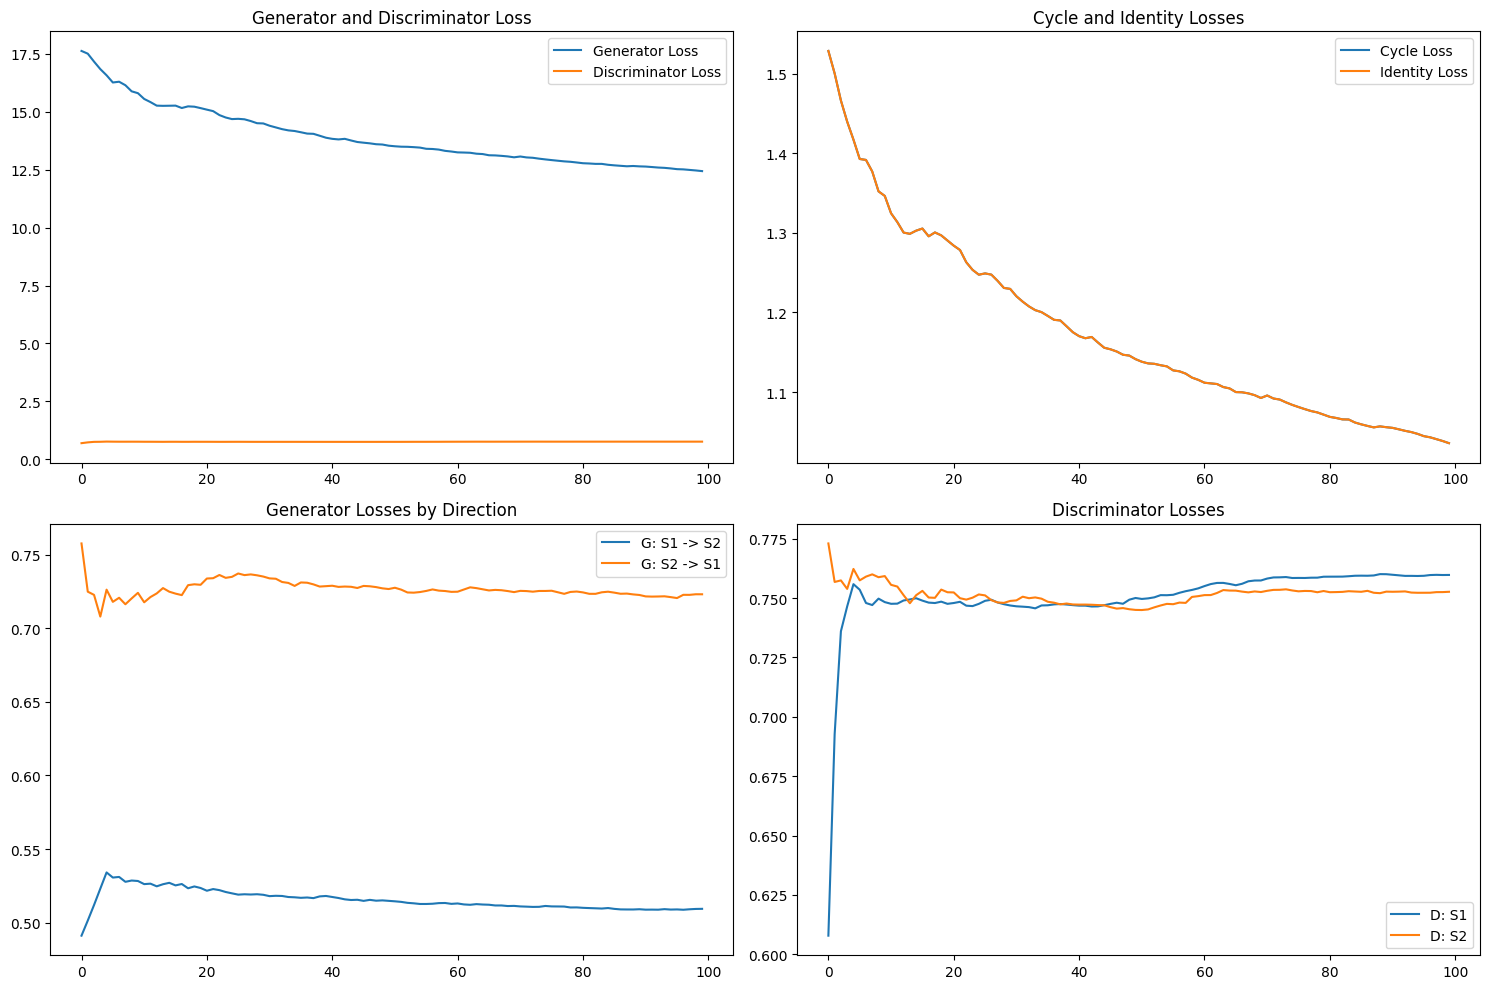

CycleGAN training complete!


In [38]:

def hyperparameter_tuning(data_splits, input_dims, param_grid):
    """
    Simple hyperparameter tuning for the CycleGAN model
    
    Parameters:
    -----------
    data_splits : tuple
        The data splits from train_test_validation_split
    input_dims : int
        Dimension of the input features
    param_grid : dict
        Dictionary of hyperparameter options to try
        
    Returns:
    --------
    tuple : (best_params, best_metrics)
    """
    X_train, stage1_train, stage2_train, X_val, stage1_val, stage2_val, _, _, _ = data_splits
    
    # Use a small subset for faster tuning
    subset_size = min(1000, X_train.shape[0])
    idx = np.random.choice(X_train.shape[0], subset_size, replace=False)
    X_subset = X_train[idx]
    stage1_subset = stage1_train[idx]
    stage2_subset = stage2_train[idx]
    
    # Track best parameters and performance
    best_params = None
    best_metrics = None
    best_loss = float('inf')
    
    # Create a directory for tuning results
    os.makedirs('tuning_results', exist_ok=True)
    
    # Simple grid search over parameters
    tuning_results = []
    
    for i, params in enumerate(param_grid):
        print(f"Tuning configuration {i+1}/{len(param_grid)}")
        print(f"Parameters: {params}")
        
        # Create and train model with current params
        model = CycleGAN(
            input_dims=input_dims,
            stage1_dims=stage1_train.shape[1],
            stage2_dims=stage2_train.shape[1],
            **params
        )
        
        # Train for a limited number of epochs
        model.train(
            input_features=X_subset,
            stage1_measurements=stage1_subset,
            stage2_measurements=stage2_subset,
            epochs=20,  # Short training for tuning
            batch_size=64,
            validate_every=5,
            sample_interval=10,
            save_model_interval=999,  # Don't save during tuning
            validation_data=(X_val, stage1_val, stage2_val)
        )
        
        # Evaluate on validation set
        metrics = model.evaluate_model(X_val, stage1_val, stage2_val)
        
        # Save this configuration and its results
        result = {
            'params': params,
            'metrics': metrics,
            'total_loss': metrics['stage1_mae'] + metrics['stage2_mae'] + 0.5 * metrics['cycle_s1_mae'] + 0.5 * metrics['cycle_s2_mae']
        }
        tuning_results.append(result)
        
        # Check if this is the best configuration
        if result['total_loss'] < best_loss:
            best_loss = result['total_loss']
            best_params = params
            best_metrics = metrics
            
        # Save intermediate results
        with open(f'tuning_results/tuning_results_{i}.json', 'w') as f:
            json.dump(result, f)
    
    # Save all tuning results
    with open('tuning_results/all_tuning_results.json', 'w') as f:
        json.dump(tuning_results, f)
        
    print("Hyperparameter tuning complete")
    print(f"Best parameters: {best_params}")
    print(f"Best metrics: {best_metrics}")
    
    return best_params, best_metrics

if __name__ == "__main__":
    # Load and prepare data
    data_splits_with_scalers = load_and_prepare_data()
    data_splits = data_splits_with_scalers[:-1]  # Extract just the data splits
    scalers = data_splits_with_scalers[-1]      # Extract the scalers
    
    # Get input dimensions
    input_dims = data_splits[0].shape[1]
    
    # Train the model with default hyperparameters
    print("Training CycleGAN with default hyperparameters...")
    model = train_cyclegan(data_splits, input_dims)
    
    # Uncomment to run hyperparameter tuning
    """
    print("Starting hyperparameter tuning...")
    param_grid = [
        {
            'gen_hidden_layers': [256, 128, 64],
            'disc_hidden_layers': [64, 32, 16],
            'gen_dropout_rate': 0.2,
            'disc_dropout_rate': 0.3,
            'gen_learning_rate': 0.0002,
            'disc_learning_rate': 0.0002,
            'lambda_cycle': 10.0,
            'lambda_identity': 1.0
        },
        {
            'gen_hidden_layers': [512, 256, 128],
            'disc_hidden_layers': [128, 64, 32],
            'gen_dropout_rate': 0.3,
            'disc_dropout_rate': 0.4,
            'gen_learning_rate': 0.0001,
            'disc_learning_rate': 0.0001,
            'lambda_cycle': 15.0,
            'lambda_identity': 0.5
        },
        {
            'gen_hidden_layers': [128, 64],
            'disc_hidden_layers': [32, 16],
            'gen_dropout_rate': 0.1,
            'disc_dropout_rate': 0.2,
            'gen_learning_rate': 0.0005,
            'disc_learning_rate': 0.0005,
            'lambda_cycle': 5.0,
            'lambda_identity': 2.0
        }
    ]
    
    best_params, best_metrics = hyperparameter_tuning(data_splits, input_dims, param_grid)
    
    # Train final model with best parameters
    print("Training final model with best hyperparameters...")
    model = train_cyclegan(data_splits, input_dims, best_params)
    """
    
    print("CycleGAN training complete!") 

# References

# Melt Down long Data sets for plottong
https://dotnetfiddle.net/Rmlhy0

# Keras Deep LEarning Examples (Provided by Instructor)
https://keras.io/examples/